In [1]:
import numpy as np
import matplotlib.pyplot as plt

Выполнил не совсем то, что требуется в задании, вместо этого попытался выполнить свою реализацию алгоритма с некоторой аналитикой.

Если же принципиально конкретно ДЗ, то:
* Примеры параметров для обучения в первом задании: `alpha = 1e-2`, `n = 1500`
* Во втором пункте нужно использовать скалярное произведение при умножении признаков на отклонения (`@` или `np.dot()`) и убрать сумму. 

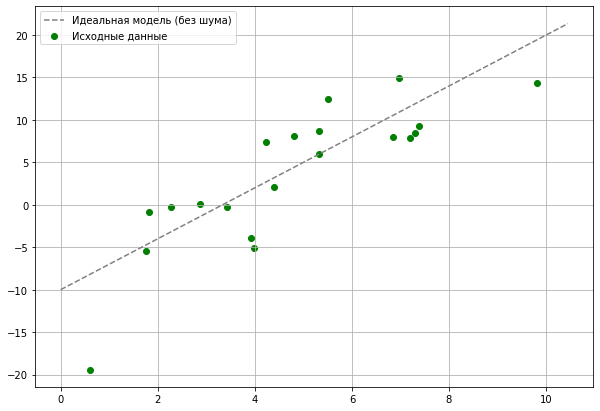

In [2]:
np.random.seed(123)

w0, w1 = -10, 3
n = 20

ox = np.arange(0, 11, 11 / n)
oy = ox * w1 + w0

X = np.random.random(n) * 10
X = np.array((np.ones_like(X.T), X.T))
y = np.random.normal(w0, 4, n) + w1 * X[1]

fig = plt.figure(figsize=(10, 7))

plt.scatter(X[1], y, color='green', label='Исходные данные')
plt.plot(ox, oy, color='grey', label='Идеальная модель (без шума)', linestyle = '--')
plt.legend(loc='best')
plt.grid()
plt.show()


In [8]:
def rmse(y, y_pred):
    '''
    Считает корень из среднеквадратичного отклонения двух последовательностей
    '''
    return ((y-y_pred)**2).mean()**0.5

def mae(y, y_pred):
    '''
    Считает средний модуль отклонений двух последовательностей
    '''
    return (np.abs(y-y_pred)).mean()

def lin_regression(X: np.array, y: np.array, step=1e-4, max_n_iter=8e4, min_by='mae', verbose=False, reducing=0):
    '''
    Считает коэффициенты линейной регрессии для вводимых признаков X (np.array) и целевой y (np.array).
    step - шаг обучения (leaning rate)
    max_n_iter - максимальное число шагов обучения
    min_by - функция потерь, по которой производится минимазация ошибки
    verbose - для получения доп. инфо на каждом 10 шаге обучения
    reducing - коэффициент, сокращающий каждый следующий step. 0 говорит о том, что step остается неизменным.
    
    Возвращает кортеж из списка весов коэффициентов (np.array) и выбранную метрику на каждом 10 шаге (list) 
    '''
    W = np.zeros_like(X[:,0])
    
    metrics = []
    n_iter, W_dif = 1, np.inf

    while n_iter < max_n_iter:# and W_dif > min_dif:
        W_old = W.copy()
        if min_by == 'mae':
            grad = np.dot(X, np.sign(np.dot(W, X) - y))
        elif min_by == 'mse':
            grad = 2 * np.dot(X, (np.dot(W, X) - y))
        W -= step / (n_iter**reducing) * grad
#         W_dif = np.abs(W_old - W).sum()
        if not (n_iter - 1) % 10:
            if verbose:
                print(W, W_dif)
            if min_by == 'mae':
                metrics.append(mae(y, np.dot(W, X)))
            elif min_by == 'mse':
                metrics.append(rmse(y, np.dot(W, X)))
        n_iter += 1
    if verbose:
        print(W, n_iter, W_dif, grad)
    return W, metrics


Построим графики для минимизации по MSE и по MAE:

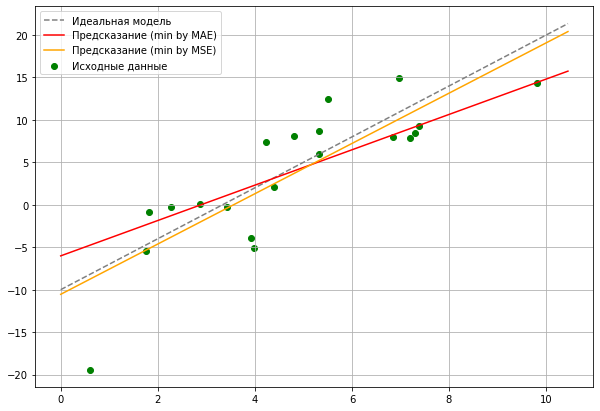

In [7]:
W_mse, custom_mse = lin_regression(X, y, min_by='mse')
W_mae, custom_mae = lin_regression(X, y, min_by='mae')

fig = plt.figure(figsize=(10, 7))

plt.scatter(X[1], y, color='green', label='Исходные данные')
plt.plot(ox, oy, color='grey', label='Идеальная модель', linestyle = '--')

plt.plot(ox, ox * W_mae[1] + W_mae[0], color='red', label='Предсказание (min by MAE)')
plt.plot(ox, ox * W_mse[1] + W_mse[0], color='orange', label='Предсказание (min by MSE)')

plt.legend(loc='best')
plt.grid()
plt.show()


Как видно, минимизация по MAE более хорошо описала основную массу наблюдений.

Модель, минимизирующая MSE явно учла выброс слева и при этом почти совпадает с графиком, по которому изначально синтезировались данные. Это скорее лучше списать на совпадение.

Рассмотрим скорость обучения этих разных подходов и вид полученных графиков:

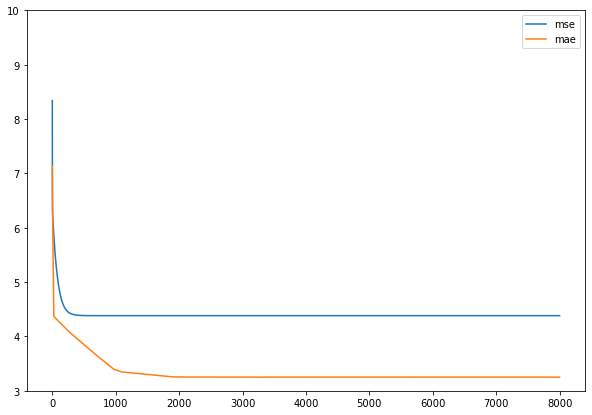

In [9]:
fig = plt.figure(figsize=(10, 7))
plt.plot(custom_mse, label='mse')
plt.plot(custom_mae, label='mae')
plt.legend(loc='best')
plt.ylim(3, 10)
plt.show()


При минимизации MAE график получился более ломаный, что скорее связано со спецификой постоянности производной модуля  на положительном/отрицательном множестве, а также выбранным постоянным шагом. При снижении шага график должен сглаживаться.

Отдельно построим сначала для метода с минимизацией MSE, а затем MAE распределения скорости снижения метрики от числа итераций для разных скоростей обучения:

Для шага 0.002 значение MSE на последней итерации: 4.382291463802841
Для шага 0.0004 значение MSE на последней итерации: 4.382291463802841
Для шага 8e-05 значение MSE на последней итерации: 4.38229146380284
Для шага 1.6e-05 значение MSE на последней итерации: 4.382291463802841
Для шага 3.2e-06 значение MSE на последней итерации: 4.382291463803741
Для шага 6.4e-07 значение MSE на последней итерации: 4.382291463909262
Для шага 1.28e-07 значение MSE на последней итерации: 4.382291467019571
Для шага 2.56e-08 значение MSE на последней итерации: 4.382291505254269


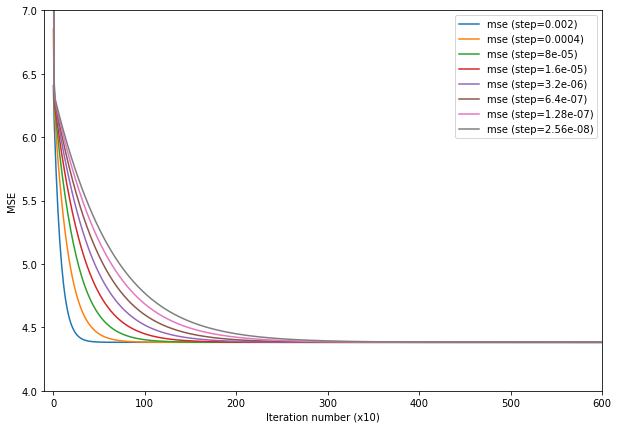

In [16]:
fig = plt.figure(figsize=(10, 7))

crit_mse = np.array([[], []])

step = 0.01

for i in range(1, 9):
    W_mse, custom_mse = lin_regression(X, y, min_by='mse', step=step / 10 / i, max_n_iter=10000)
    custom_mse = np.array(custom_mse)
    crit_mse = np.hstack((crit_mse, [[step / 10 / i], [np.where(custom_mse > 4.383)[0].shape[0] * 10]]))
    plt.plot(custom_mse, label=f'mse (step={step / 5**i})')
    print(f'Для шага {step / 5**i} значение MSE на последней итерации: {custom_mse[-1]}')
plt.xlim(-10, 600)
plt.ylim(4, 7)
plt.legend(loc='best')
plt.xlabel('Iteration number (x10)')
plt.ylabel('MSE')

plt.show()

Для шага 0.002 значение MAE на последней итерации: 3.2606782779642507
Для шага 0.0004 значение MAE на последней итерации: 3.253638555022468
Для шага 8e-05 значение MAE на последней итерации: 3.252854071175989
Для шага 1.6e-05 значение MAE на последней итерации: 3.2526825341112158
Для шага 3.2e-06 значение MAE на последней итерации: 3.2527762528763544
Для шага 6.4e-07 значение MAE на последней итерации: 3.252198172323104
Для шага 1.28e-07 значение MAE на последней итерации: 3.251857061053115
Для шага 2.56e-08 значение MAE на последней итерации: 3.2517834330934625


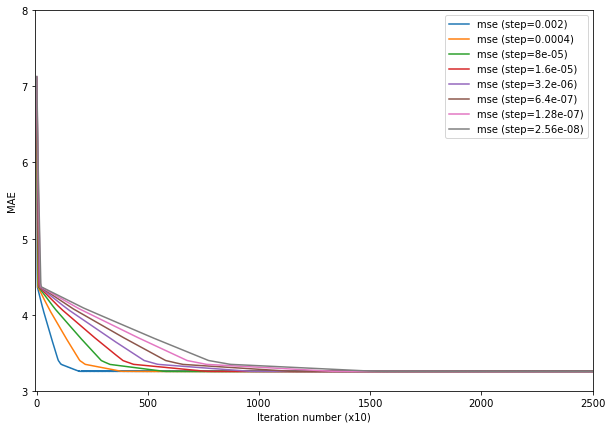

In [17]:
fig = plt.figure(figsize=(10, 7))

crit_mae = np.array([[], []])

step = 0.01

for i in range(1, 9):
    W_mse, custom_mae = lin_regression(X, y, min_by='mae', step=step / 10 / i, max_n_iter=30000)
    custom_mae = np.array(custom_mae)
    crit_mae = np.hstack((crit_mae, [[step / 10 / i], [np.where(custom_mae > 3.255)[0].shape[0] * 10]]))
    plt.plot(custom_mae, label=f'mse (step={step / 5**i})')
    print(f'Для шага {step / 5**i} значение MAE на последней итерации: {custom_mae[-1]}')
plt.xlim(-10, 2500)
plt.ylim(3, 8)
plt.legend(loc='best')
plt.xlabel('Iteration number (x10)')
plt.ylabel('MAE')

plt.show()

Четко видно, что начиная с какого-то шага последующие значения метрики не снижаются, а значит можно выбрать такие критические итерации, больше которых смысла считать нет:

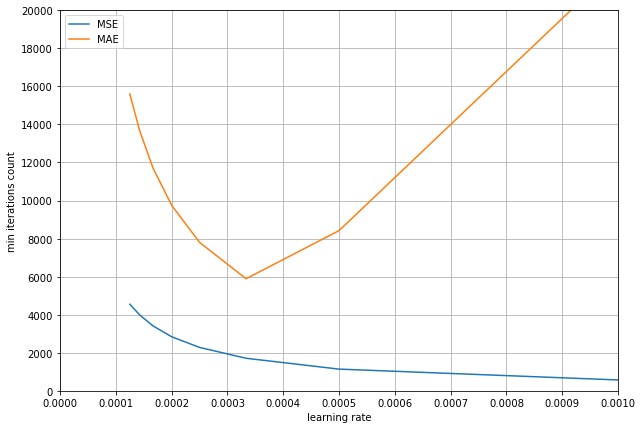

In [18]:
fig = plt.figure(figsize=(10, 7))

plt.plot(crit_mse[0], crit_mse[1], label='MSE')
plt.plot(crit_mae[0], crit_mae[1], label='MAE')
plt.xlabel('learning rate')
plt.ylabel('min iterations count')
plt.legend()
ticks_left = np.linspace(0,20000,11)
ticks_bottom = np.linspace(0,0.001,11)
plt.xlim(0.0001, 0.001)
plt.ylim(0, 20000)
plt.yticks(ticks_left)
plt.xticks(ticks_bottom)
plt.grid()
plt.show()


Таким образом для метода с MSE зависимость получилась прямая и можно дял каждого шага определить оптимальное число итераций. Для MAE же ситуация интереснее: минимальное число итераций (~6000) потребуется при шаге приблизительно в 0.00035, если же он будет больше или меньше, то число итерация для достижения стабильного результата будет расти.

Более того тот факт, что при большой скорости обучения количество итераций растет, заставляет задуматься о том, что результат может быть даже попросту не стабильным:

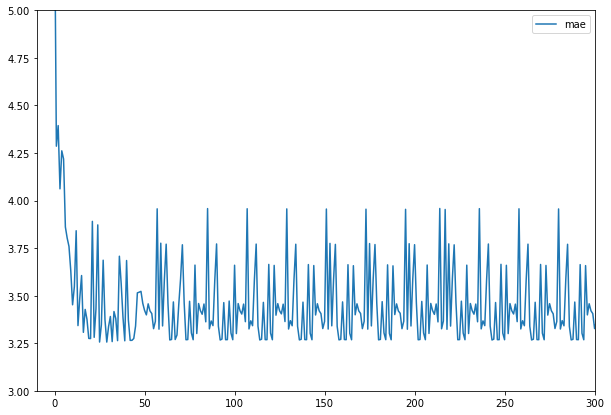

In [13]:
W_mae, custom_mae = lin_regression(X, y, min_by='mae', step=0.01)
fig = plt.figure(figsize=(10, 7))
plt.plot(custom_mae, label='mae')
plt.legend(loc='best')
plt.ylim(3, 5)
plt.xlim(-10, 300)
plt.show()

Действительно, при большых значениях скорости обучения и постоянном шаге (важно) попадаем в ситуацию, когда постоянно "перепрыгиваем" через минимум, для борьбы  счем можно уменьшить скорость спуска или сделать шаг не постоянным.